In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import soundfile
import numpy as np
import pandas as pd
import librosa
import glob
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def trim_to_3sec(audio,sample_rate):
  max_length = sample_rate*3
  return(audio[:max_length])

def pad_to_3sec(audio,sample_rate):
  min_length = sample_rate*3
  requ_padding = min_length - len(audio)
  return(np.append(audio,np.zeros(requ_padding)))

def normalize(audio):
  return(audio * (1/max(audio)))

def extract_feature(file_name):
  #Read the sound file
    with soundfile.SoundFile(file_name) as sound_file:
        X,sample_rate = librosa.load(file_name)
        # X = sound_file.read(dtype="float32")
        X  = X[:,0] if len(X.shape)>1 else X
        normalize(X)
        # sample_rate = sound_file.samplerate

  #Prepare the file to the required length
        if(len(X)>3*sample_rate):
          X = trim_to_3sec(X,sample_rate)
        elif(len(X)<3*sample_rate):
          X = pad_to_3sec(X,sample_rate)
  #Extract the feature from the raw audio
    mfccs = (librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T).flatten()
    return(mfccs)

In [ ]:
EMOTION_MAP = {
    "neutral" : 1,
    "calm" : 2,
    "happy" : 3,
    "sad" : 4,
    "angry" : 5,
    "fear" : 6,
    "disgust" : 7,
    "ps" : 8 #surprise
    }

In [ ]:
def load_data(test_size=0.2):
  X, y = [], []
  df  = pd.read_csv("/content/drive/MyDrive/Data/index.csv")
  X = [extract_feature(i) for i in df['Filepath']]
  y = [i-1 for i in df['Emotion']]
  return(train_test_split(np.array(X), np.array(y), test_size=test_size, random_state=7))

In [ ]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(2600,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(y_train)
print(X_train.shape,y_train.shape)

encoder.fit(y_test)
y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(y_test)

(3180, 2600) (3180, 8)


In [ ]:
cnnhistory=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
199/199 [==============================] - 5s 19ms/step - loss: 15.6190 - accuracy: 0.2198 - val_loss: 10.1780 - val_accuracy: 0.2330
Epoch 2/100
199/199 [==============================] - 3s 17ms/step - loss: 5.8008 - accuracy: 0.3893 - val_loss: 3.4697 - val_accuracy: 0.3745
Epoch 3/100
199/199 [==============================] - 2s 11ms/step - loss: 2.7555 - accuracy: 0.4789 - val_loss: 1.2466 - val_accuracy: 0.5557
Epoch 4/100
199/199 [==============================] - 2s 11ms/step - loss: 1.5047 - accuracy: 0.5604 - val_loss: 1.0246 - val_accuracy: 0.6698
Epoch 5/100
199/199 [==============================] - 2s 9ms/step - loss: 1.1234 - accuracy: 0.6453 - val_loss: 0.9818 - val_accuracy: 0.6745
Epoch 6/100
199/199 [==============================] - 2s 9ms/step - loss: 0.9557 - accuracy: 0.6830 - val_loss: 0.9660 - val_accuracy: 0.6887
Epoch 7/100
199/199 [==============================] - 2s 11ms/step - loss: 0.8675 - accuracy: 0.7204 - val_loss: 0.8428 - val_accuracy:

In [ ]:
def pred_from_file(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
      X,sample_rate = librosa.load(file_name)
      # X = sound_file.read(dtype="float32")
      X  = X[:,0] if len(X.shape)>1 else X
      normalize(X)
      # sample_rate = sound_file.samplerate

#Prepare the file to the required length
      if(len(X)>3*sample_rate):
        X = trim_to_3sec(X,sample_rate)
      elif(len(X)<3*sample_rate):
        X = pad_to_3sec(X,sample_rate)
  #Extract the feature from the raw audio
    mfccs = (librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T).flatten()
    X = np.array([mfccs])
    return(model.predict(X))

In [ ]:
pred_from_file("/content/drive/MyDrive/Data/Actor_01/03-01-01-01-01-01-01.wav")

1/1 [==============================] - 0s 103ms/step


array([[3.3120447e-01, 1.2763744e-04, 6.4874405e-01, 5.3969452e-06,
        1.5990712e-03, 1.3015400e-02, 1.9356421e-05, 5.2845976e-03]],
      dtype=float32)

In [ ]:
def silence_suppression(X):
  for i in range(len(X)):
    if(X[i]!=0):
      break
  X = X[i:]

  for i in range(len(X)-1,0,-1):
    if(X[i]!=0):
      break
  X = X[:i]

  return(X)

def pred_from_large_file(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
      X,sample_rate = librosa.load(file_name)
      X  = X[:,0] if len(X.shape)>1 else X

      X = silence_suppression(X)
      if(len(X)%(3*sample_rate)!=0):
        requ_padding = 3*sample_rate - len(X)%(3*sample_rate)
        X = (np.append(X,np.zeros(requ_padding)))

      data_list = []
      for i in range(0,len(X),3*sample_rate):
        data_list.append(X[i:i+3*sample_rate+1])

      #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0)
      X_data = np.array([(librosa.feature.mfcc(y=i, sr=sample_rate, n_mfcc=20).T).flatten() for i in data_list])
      print(X_data[0].shape)
      return(model.predict(X_data))

In [ ]:
Filepath = "/content/drive/MyDrive/laptop.wav"

data = pred_from_large_file(Filepath)

(2600,)
11/11 [==============================] - 0s 5ms/step


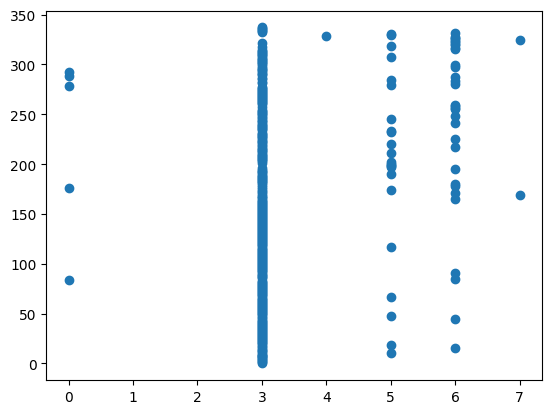

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.argmax(data,axis=1),range(len(data)))

In [ ]:
model.save('Best_model')

In [ ]:
new_model = keras.models.load_model('Best_model')

In [ ]:
def silence_suppression(X):
  for i in range(len(X)):
    if(X[i]!=0):
      break
  X = X[i:]

  for i in range(len(X)-1,0,-1):
    if(X[i]!=0):
      break
  X = X[:i]

  return(X)

def pred_from_large_file(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
      X,sample_rate = librosa.load(file_name)
      X  = X[:,0] if len(X.shape)>1 else X

      X = silence_suppression(X)
      if(len(X)%(3*sample_rate)!=0):
        requ_padding = 3*sample_rate - len(X)%(3*sample_rate)
        X = (np.append(X,np.zeros(requ_padding)))

      data_list = []
      for i in range(0,len(X),3*sample_rate):
        data_list.append(X[i:i+3*sample_rate+1])

      #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0)
      X_data = np.array([(librosa.feature.mfcc(y=i, sr=sample_rate, n_mfcc=20).T).flatten() for i in data_list])
      print(X_data[0].shape)
      return(new_model.predict(X_data))

In [ ]:
Filepath = "/content/drive/MyDrive/TestFile.wav"

data = pred_from_large_file(Filepath)

(2600,)
3/3 [==============================] - 0s 8ms/step


In [ ]:
for i in (data):
  print(np.argmax(i))

3
3
3
5
5
5
6
3
5
3
5
4
6
3
3
3
4
5
3
6
5
4
5
5
2
3
3
3
5
3
5
3
3
4
5
5
3
5
3
5
3
4
3
3
4
6
5
3
3
6
6
5
4
4
5
3
5
5
3
6
5
5
6
5
4
4
5
2
4
4
4
4
5
6
4
5
3
3
3
3
5
